In [ ]:
from scipy.integrate import odeint
import math
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#  Fitzhugh Nagumo model in oscillatory mode
In this example we will use PyMC3 to infer the parameters of the Fitzhugh-Nagumo oscillator. It is a simple model that 
generates action potentials. The model is describes as:

\begin{align}
\frac{dV}{dt}&=(V - \frac{V^3}{3} + R)c\\
\frac{dR}{dt}&=\frac{-(V-a+bR)}{c},
\end{align}
where $a$, $b$, $c$ are the model parameters.

We start by defining our ODE solver. In this case we will be using scipy odeint. However, note that we can also wrapp any other solver written in say C++. The point I am trying to drive home is that we are free to call up any model solver as long as it is available in python.

In [2]:
class FitzhughNagumoModel(object):

    def __init__(self, n_state, n_params, times, y0=None):

        if y0 is None:
            self._y0 = np.array([-1, 1], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
        self._n_states = 2
        self._n_params = 3
        self._times = times
        self._T = len(times)
            
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):
        #print(parameters.shape)
        a, b, c = [float(x) for x in parameters]
        

        def r(y, t, p):
            V, R = y
            dV_dt = (V - V**3 / 3 + R) * c
            dR_dt = -(V - a + b * R) /c
            return dV_dt, dR_dt

        if sensitivities:
            def jac(y):
                V, R = y
                ret = np.empty((2, 2))
                ret[0, 0] = c*(1-V**2)
                ret[0, 1] = c
                ret[1, 0] = -1 / c
                ret[1, 1] = -b / c
                return ret

            def dfdp(y):
                V, R = y
                ret = np.empty((2, 3))
                ret[0, 0] = 0
                ret[0, 1] = 0
                ret[0, 2] = R - V**3/3 + V
                ret[1, 0] = 1 / c
                ret[1, 1] = -R / c
                ret[1, 2] = (R * b + V - a) / c**2
                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((self._n_states,
                                                            self._n_params))

                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)

                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros(self._n_states + (self._n_states * self._n_params))
            y0[0:self._n_states] = self._y0
            result = odeint(rhs, y0, self._times, (parameters,), rtol=1e-6, atol=1e-7)
            values = result[:, 0:self._n_states]
            dvalues_dp = result[:, self._n_states:].reshape(
                (self._T, self._n_states, self._n_params))
            return values, dvalues_dp
        else:
            values = odeint(r, self._y0, self._times, (parameters,), rtol=1e-6, atol=1e-7)
            return values


## Generate simulated trajectories with Gaussian noise

Text(0, 0.5, 'Value')

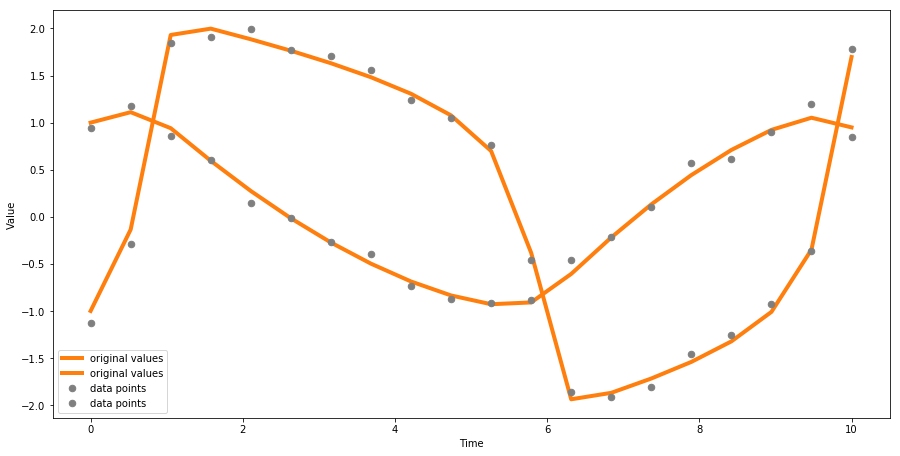

In [3]:
times = np.linspace(0, 10, 20)
fn_ode_model = FitzhughNagumoModel(2, 3, times)
sigma=0.1
real_params = [0.2,0.2,3.]
sol=fn_ode_model.solve(real_params)
Y=sol+np.random.randn(20,2)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

## Caching as in Theano `op`

In [4]:
class solveCached(object):
    def __init__(self, ode_model):
      
        self._ode_model = ode_model    
        self._cachedParam = np.zeros(ode_model._n_params)
        self._cachedSens = np.zeros((ode_model._T, ode_model._n_states, ode_model._n_params))
        self._cachedState = np.zeros((ode_model._T,ode_model._n_states))
        
    def __call__(self, p):
        
        if np.all(p==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            state, sens = self._ode_model.solve_with_sensitivities(p)
        
        return state, sens, self._ode_model._T, self._ode_model._n_states, self._ode_model._n_params

cached_solver=solveCached(fn_ode_model)

In [5]:
def state(p):
    State, Sens, T, k, d = cached_solver(np.array(p,dtype=np.float32))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, p
    return State

def numpy_vjp(p, grad_output):    
    numpy_sens, T, k, d = cached_solver(np.array(p,dtype=np.float32))[1:]
    
    numpy_sens = numpy_sens.reshape((k*T,d))
    return numpy_sens.T.dot(grad_output)

## Custom ODE op using `tf.py_func`

By default vectorisation is enabled. The sensitivity evaluation can be easily done in parallel.

In [6]:
import uuid

num_mc_samples = 2
def ODEop(inputs):
    forProp = np.zeros((num_mc_samples,20,2),dtype=np.float32)
    dpar = np.zeros((num_mc_samples,3),dtype=np.float32)
    def _ODEop(x):
        
        for i in range(num_mc_samples):
            forProp[i,:,:] = state(x[i])

        return forProp

    def _ODEop_grad(x,v):
        print('V: ',v.shape)
        
        for j in range(num_mc_samples):
            dpar[j,:] = numpy_vjp(x[j])

        return   

    def _ODEop_grad_op(op, grad):
        
        x = op.inputs[0]
        x_grad = tf.py_func(_ODEop_grad, [x,grad], tf.float32)
   
        return x_grad

    # Register the gradient with a unique id
    grad_name = "ScipyODEGrad_" + str(uuid.uuid4())
    tf.RegisterGradient(grad_name)(_ODEop_grad_op)

    # Override the gradient of the custom op
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": grad_name}):
        output = tf.py_func(_ODEop, [inputs], tf.float32)
    return output

In [7]:
tfd = tf.contrib.distributions ##Update to latest
ds=tfd

## Prior as a transformed density on unconstrained parameter

We use `bijectors` for change of random variable and build transformed distribution. [STAN Manual](https://mc-stan.org/docs/2_21/reference-manual/change-of-variables-section.html) provides a handy reference.

In building the prior, likelihood and the q() distribution we heavily use `tf.make_template`. Makes implementation easier.

In [8]:
def make_prior(nparams=3):

    log_gamma = tfd.TransformedDistribution(distribution=tfd.Independent(
    distribution=tfd.Gamma(concentration =[2.2,2.2, 1.6],rate =[0.1,0.1,0.1]),
    reinterpreted_batch_ndims=1),bijector = ds.bijectors.Inline(
                                forward_fn=tf.log,
                                inverse_fn=tf.exp,
                                inverse_log_det_jacobian_fn=(
                                lambda y: tf.reduce_sum(y, axis=-1)),
                                forward_min_event_ndims=1)
    ,name="LogGamaTransformedDistribution")
    return log_gamma

# The Gaussian likelihood is built on the constrained space

In [9]:
def make_likelihood(theta):
    phi = tf.exp(theta)

    sol=ODEop(phi)

    const_sigmas = tf.ones((1,2))*0.1 # noise considered known
    base = tfd.MultivariateNormalDiag(loc = sol ,scale_diag=const_sigmas)
    lik = tfd.Independent(
    distribution=base,
    reinterpreted_batch_ndims=1)
    return lik

## Mean-field approximation

In [10]:
def make_qdistribution(nparams):

    with tf.variable_scope("modell",reuse=tf.AUTO_REUSE):
        q_means = tf.get_variable("qtheta/loc", [3])
        q = tfd.Normal(loc=q_means,
                scale=tf.nn.softplus(tf.get_variable("qtheta/scale", [3])) )
        qtheta = tfd.Independent(
        distribution=q,
        reinterpreted_batch_ndims=1)
    
    return qtheta, q_means
    

In [11]:
make_qdistribution = tf.make_template('qdistribution', make_qdistribution)
make_likelihood = tf.make_template('likelihood', make_likelihood)
make_prior = tf.make_template('prior', make_prior)

## Define the ELBO using `tfp`'s spify `tfp.monte_carlo.expectation` method. Basically calculates the MC ELBO.

In [ ]:
data = tf.placeholder(tf.float32,[20,2])
posterior, qloc = make_qdistribution(3)
def ELBO(x):
    
    l = make_likelihood(x).log_prob(data) + make_prior(3).log_prob(x)
    return l

p=posterior

elbo = tfp.monte_carlo.expectation(
    f=ELBO,
    samples=p.sample(num_mc_samples),
    log_prob=p.log_prob,
    axis=0,
    use_reparametrization=(p.reparameterization_type
                           == tfp.distributions.FULLY_REPARAMETERIZED))
elbo += posterior.entropy()

samples = posterior.sample(1000)

optimize = tf.train.AdamOptimizer(learning_rate=0.01).minimize(-elbo)

In [13]:
y=Y
#config = tf.ConfigProto(inter_op_parallelism_threads=10) <----For older TensorFlow version (scipy odeint clashes)
init = tf.global_variables_initializer()
test_elbo = []
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(5000):
        
        sess.run([optimize], {data: y})
        test_elbo.append(sess.run([elbo], {data: y})) 
        if epoch % 500 ==0:
            means = sess.run([tf.reduce_mean(tf.exp(samples),axis=0)], {data: y})
            elbo_meter = np.array(test_elbo)
            mean_elbo = np.mean(elbo_meter[-10:])
            
            print('Epoch', epoch, 'elbo', mean_elbo)
            print('Epoch', epoch, 'Means', means)           
        
    pos_samples=sess.run([samples], {data: y})
    

Epoch 0 elbo -6983.9463
Epoch 0 Means [array([1.3793681 , 2.1265001 , 0.49460107], dtype=float32)]
Epoch 500 elbo -4616.3726
Epoch 500 Means [array([0.74154204, 2.6934204 , 0.6587099 ], dtype=float32)]
Epoch 1000 elbo -4179.4746
Epoch 1000 Means [array([0.46271443, 2.5641088 , 0.7915398 ], dtype=float32)]
Epoch 1500 elbo -3797.9348
Epoch 1500 Means [array([0.28068534, 1.9271444 , 0.90372777], dtype=float32)]
Epoch 2000 elbo -2611.8994
Epoch 2000 Means [array([0.26325217, 0.86868757, 1.2146038 ], dtype=float32)]
Epoch 2500 elbo -1199.6294
Epoch 2500 Means [array([0.21597584, 0.4393032 , 2.4702027 ], dtype=float32)]
Epoch 3000 elbo -504.94086
Epoch 3000 Means [array([0.18222643, 0.3929723 , 2.7282674 ], dtype=float32)]
Epoch 3500 elbo -248.98218
Epoch 3500 Means [array([0.1458852 , 0.33190823, 2.8692741 ], dtype=float32)]
Epoch 4000 elbo -145.22884
Epoch 4000 Means [array([0.14150396, 0.29574245, 3.0457652 ], dtype=float32)]
Epoch 4500 elbo -118.36308
Epoch 4500 Means [array([0.14230904,

## Visualise the Marginals

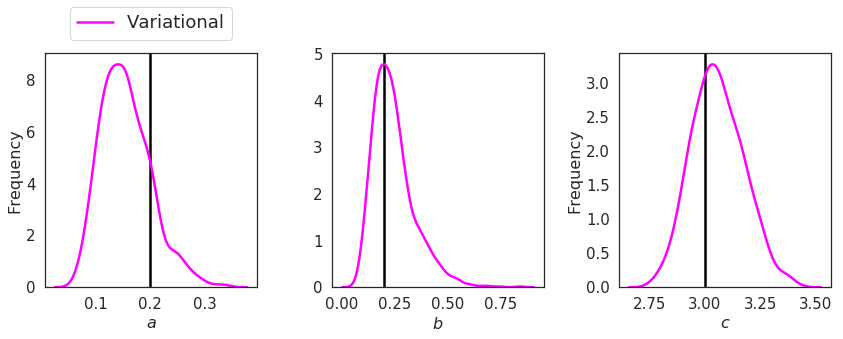

In [18]:
vb_params=np.exp(pos_samples[0])
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(12,5),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")

param_names = [r"$a$", r"$b$", r"$c$"]

for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(1, 3, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')

        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
         
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()